In [1]:
import pandas as pd
import os
import numpy as np
import time
import tensorflow.keras.initializers
import statistics
import tensorflow.keras as keras
from sklearn import metrics
import tensorflow as tf
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Lambda, Flatten, Reshape, LeakyReLU, Dense, Activation, Dropout, InputLayer, Input
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import ShuffleSplit
from tensorflow.keras.layers import ReLU
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from bayes_opt import BayesianOptimization
import matplotlib.pyplot as plt
import scipy.interpolate
import logging, os
from IPython import display
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

%matplotlib inline
import matplotlib
matplotlib.style.use('seaborn')

In [2]:
# ~~~ ADDED ~~ ##

# Data directly taken from PDF
Ebins = np.array([1.00E-03,2.15E-03,4.64E-03,1.00E-02,2.15E-02,4.64E-02,1.00E-01,2.15E-01,4.64E-01,1.00E+00,2.15E+00,4.64E+00,1.00E+01,2.15E+01,4.64E+01,1.00E+02,2.15E+02,4.64E+02,1.00E+03,2.15E+03,4.64E+03,1.00E+04,1.25E+04,1.58E+04,1.99E+04,2.51E+04,3.16E+04,3.98E+04,5.01E+04,6.30E+04,7.94E+04,1.00E+05,1.25E+05,1.58E+05,1.99E+05,2.51E+05,3.16E+05,3.98E+05,5.01E+05,6.30E+05,7.94E+05,1.00E+06,1.25E+06,1.58E+06,1.99E+06,2.51E+06,3.16E+06,3.98E+06,5.01E+06,6.30E+06,7.94E+06,1.00E+07,1.58E+07])

EbinsExtended = np.array([1.00E-03,2.15E-03,4.64E-03,1.00E-02,2.15E-02,4.64E-02,1.00E-01,2.15E-01,4.64E-01,1.00E+00,2.15E+00,4.64E+00,1.00E+01,2.15E+01,4.64E+01,1.00E+02,2.15E+02,4.64E+02,1.00E+03,2.15E+03,4.64E+03,1.00E+04,1.25E+04,1.58E+04,1.99E+04,2.51E+04,3.16E+04,3.98E+04,5.01E+04,6.30E+04,7.94E+04,1.00E+05,1.25E+05,1.58E+05,1.99E+05,2.51E+05,3.16E+05,3.98E+05,5.01E+05,6.30E+05,7.94E+05,1.00E+06,1.25E+06,1.58E+06,1.99E+06,2.51E+06,3.16E+06,3.98E+06,5.01E+06,6.30E+06,7.94E+06,1.00E+07,1.58E+07, 2.51E+07])
lethargies = []
for i in range(len(Ebins)):
    lethargies.append(np.log(EbinsExtended[i + 1]) - np.log(EbinsExtended[i]))
    
cm = np.array([
[6.11E+00,5.60E+00,4.80E+00,3.89E+00,3.03E+00,2.27E+00,1.64E+00,1.17E+00,8.20E-01,5.72E-01,3.94E-01,2.73E-01,1.90E-01,1.28E-01,8.88E-02,6.02E-02,4.05E-02,2.79E-02,1.91E-02,1.27E-02,9.01E-03,6.86E-03,6.24E-03,5.62E-03,4.99E-03,4.37E-03,3.83E-03,3.36E-03,2.90E-03,2.43E-03,1.97E-03,1.64E-03,1.47E-03,1.31E-03,1.15E-03,9.96E-04,8.95E-04,8.61E-04,8.28E-04,7.94E-04,7.60E-04,7.22E-04,6.79E-04,6.37E-04,5.94E-04,5.51E-04,4.94E-04,4.19E-04,3.44E-04,2.70E-04,1.97E-04,1.39E-04,1.00E-04],
[7.36E-01,8.08E-01,9.34E-01,1.12E+00,1.36E+00,1.72E+00,2.11E+00,2.38E+00,2.47E+00,2.46E+00,2.37E+00,2.24E+00,2.04E+00,1.85E+00,1.65E+00,1.47E+00,1.30E+00,1.14E+00,1.01E+00,8.83E-01,7.64E-01,6.98E-01,6.69E-01,6.39E-01,6.09E-01,5.81E-01,5.54E-01,5.26E-01,4.99E-01,4.71E-01,4.41E-01,4.09E-01,3.77E-01,3.45E-01,3.13E-01,2.81E-01,2.49E-01,2.17E-01,1.87E-01,1.59E-01,1.34E-01,1.11E-01,9.38E-02,7.58E-02,5.80E-02,4.42E-02,3.52E-02,2.63E-02,1.95E-02,1.52E-02,1.10E-02,7.43E-03,4.65E-03],
[5.98E-01,6.57E-01,7.58E-01,9.00E-01,1.08E+00,1.42E+00,1.89E+00,2.27E+00,2.51E+00,2.65E+00,2.69E+00,2.67E+00,2.58E+00,2.45E+00,2.29E+00,2.14E+00,1.98E+00,1.83E+00,1.67E+00,1.53E+00,1.39E+00,1.31E+00,1.27E+00,1.23E+00,1.20E+00,1.16E+00,1.13E+00,1.09E+00,1.05E+00,1.02E+00,9.77E-01,9.33E-01,8.87E-01,8.35E-01,7.78E-01,7.19E-01,6.57E-01,5.94E-01,5.27E-01,4.61E-01,3.96E-01,3.39E-01,2.90E-01,2.42E-01,1.94E-01,1.54E-01,1.24E-01,9.54E-02,7.21E-02,5.66E-02,4.15E-02,2.81E-02,1.77E-02],
[5.01E-01,5.50E-01,6.34E-01,7.50E-01,9.18E-01,1.22E+00,1.62E+00,2.00E+00,2.31E+00,2.52E+00,2.66E+00,2.75E+00,2.75E+00,2.71E+00,2.63E+00,2.53E+00,2.41E+00,2.30E+00,2.18E+00,2.04E+00,1.92E+00,1.84E+00,1.81E+00,1.78E+00,1.74E+00,1.71E+00,1.67E+00,1.64E+00,1.61E+00,1.57E+00,1.53E+00,1.49E+00,1.44E+00,1.38E+00,1.32E+00,1.25E+00,1.17E+00,1.09E+00,9.97E-01,8.96E-01,7.96E-01,6.97E-01,6.02E-01,5.13E-01,4.24E-01,3.47E-01,2.85E-01,2.24E-01,1.77E-01,1.49E-01,1.21E-01,7.95E-02,4.26E-02],
[4.15E-01,4.55E-01,5.24E-01,6.18E-01,7.61E-01,1.01E+00,1.36E+00,1.72E+00,2.04E+00,2.27E+00,2.45E+00,2.58E+00,2.64E+00,2.67E+00,2.66E+00,2.63E+00,2.58E+00,2.51E+00,2.43E+00,2.35E+00,2.26E+00,2.21E+00,2.18E+00,2.15E+00,2.13E+00,2.10E+00,2.08E+00,2.06E+00,2.04E+00,2.02E+00,1.99E+00,1.95E+00,1.92E+00,1.88E+00,1.83E+00,1.77E+00,1.70E+00,1.61E+00,1.51E+00,1.38E+00,1.26E+00,1.13E+00,1.00E+00,8.67E-01,7.33E-01,6.13E-01,5.10E-01,4.08E-01,3.30E-01,2.80E-01,2.30E-01,1.55E-01,8.39E-02],
[3.43E-01,3.75E-01,4.31E-01,5.11E-01,6.31E-01,8.34E-01,1.12E+00,1.43E+00,1.72E+00,1.95E+00,2.13E+00,2.29E+00,2.39E+00,2.46E+00,2.50E+00,2.51E+00,2.52E+00,2.52E+00,2.47E+00,2.44E+00,2.39E+00,2.36E+00,2.35E+00,2.34E+00,2.33E+00,2.32E+00,2.31E+00,2.31E+00,2.30E+00,2.29E+00,2.28E+00,2.27E+00,2.26E+00,2.24E+00,2.22E+00,2.19E+00,2.13E+00,2.07E+00,1.97E+00,1.86E+00,1.73E+00,1.59E+00,1.42E+00,1.25E+00,1.08E+00,9.20E-01,7.60E-01,6.27E-01,5.14E-01,4.09E-01,3.03E-01,2.25E-01,1.40E-01],
[2.80E-01,3.07E-01,3.53E-01,4.23E-01,5.13E-01,6.91E-01,9.32E-01,1.18E+00,1.41E+00,1.62E+00,1.81E+00,1.95E+00,2.07E+00,2.18E+00,2.24E+00,2.29E+00,2.32E+00,2.34E+00,2.36E+00,2.36E+00,2.33E+00,2.33E+00,2.33E+00,2.33E+00,2.34E+00,2.34E+00,2.35E+00,2.37E+00,2.38E+00,2.39E+00,2.41E+00,2.43E+00,2.44E+00,2.46E+00,2.47E+00,2.47E+00,2.44E+00,2.40E+00,2.33E+00,2.23E+00,2.10E+00,1.98E+00,1.82E+00,1.63E+00,1.45E+00,1.26E+00,1.07E+00,8.88E-01,7.36E-01,6.29E-01,5.22E-01,3.61E-01,2.04E-01],
[1.85E-01,2.05E-01,2.34E-01,2.79E-01,3.42E-01,4.57E-01,6.16E-01,7.74E-01,9.38E-01,1.08E+00,1.22E+00,1.34E+00,1.44E+00,1.52E+00,1.61E+00,1.69E+00,1.74E+00,1.80E+00,1.87E+00,1.90E+00,1.92E+00,1.96E+00,1.98E+00,2.00E+00,2.02E+00,2.05E+00,2.08E+00,2.12E+00,2.16E+00,2.20E+00,2.25E+00,2.31E+00,2.37E+00,2.43E+00,2.50E+00,2.57E+00,2.62E+00,2.66E+00,2.68E+00,2.67E+00,2.61E+00,2.53E+00,2.42E+00,2.25E+00,2.06E+00,1.82E+00,1.57E+00,1.36E+00,1.16E+00,9.63E-01,7.98E-01,5.95E-01,3.53E-01],
[1.18E-01,1.30E-01,1.52E-01,1.79E-01,2.13E-01,2.91E-01,3.95E-01,5.07E-01,6.09E-01,7.04E-01,7.92E-01,8.66E-01,9.43E-01,1.02E+00,1.08E+00,1.14E+00,1.20E+00,1.25E+00,1.31E+00,1.37E+00,1.42E+00,1.46E+00,1.48E+00,1.50E+00,1.53E+00,1.55E+00,1.58E+00,1.62E+00,1.67E+00,1.73E+00,1.80E+00,1.87E+00,1.95E+00,2.05E+00,2.15E+00,2.27E+00,2.41E+00,2.52E+00,2.59E+00,2.65E+00,2.70E+00,2.71E+00,2.67E+00,2.58E+00,2.44E+00,2.25E+00,2.02E+00,1.78E+00,1.55E+00,1.31E+00,1.07E+00,8.07E-01,5.25E-01],
[7.19E-02,8.04E-02,9.38E-02,1.13E-01,1.40E-01,1.84E-01,2.52E-01,3.21E-01,3.84E-01,4.42E-01,5.04E-01,5.58E-01,6.06E-01,6.49E-01,6.77E-01,7.23E-01,7.85E-01,8.28E-01,8.73E-01,9.13E-01,9.47E-01,9.90E-01,1.01E+00,1.04E+00,1.06E+00,1.08E+00,1.12E+00,1.16E+00,1.21E+00,1.25E+00,1.32E+00,1.38E+00,1.46E+00,1.56E+00,1.68E+00,1.80E+00,1.95E+00,2.08E+00,2.22E+00,2.35E+00,2.47E+00,2.57E+00,2.65E+00,2.64E+00,2.54E+00,2.38E+00,2.16E+00,2.01E+00,1.87E+00,1.62E+00,1.31E+00,1.02E+00,6.80E-01],
[3.63E-02,4.04E-02,4.84E-02,5.66E-02,6.52E-02,8.84E-02,1.21E-01,1.55E-01,1.90E-01,2.19E-01,2.43E-01,2.75E-01,2.99E-01,3.16E-01,3.39E-01,3.64E-01,3.90E-01,4.13E-01,4.36E-01,4.68E-01,5.00E-01,5.23E-01,5.34E-01,5.45E-01,5.56E-01,5.70E-01,5.91E-01,6.15E-01,6.37E-01,6.64E-01,7.03E-01,7.52E-01,8.14E-01,8.93E-01,9.84E-01,1.08E+00,1.21E+00,1.35E+00,1.52E+00,1.69E+00,1.88E+00,2.06E+00,2.22E+00,2.35E+00,2.41E+00,2.36E+00,2.22E+00,2.13E+00,2.03E+00,1.80E+00,1.56E+00,1.24E+00,8.69E-01],
[2.72E-02,3.05E-02,3.71E-02,4.49E-02,5.41E-02,6.96E-02,9.36E-02,1.26E-01,1.48E-01,1.70E-01,1.92E-01,2.18E-01,2.33E-01,2.37E-01,2.65E-01,2.89E-01,3.08E-01,3.26E-01,3.46E-01,3.70E-01,3.83E-01,4.06E-01,4.22E-01,4.38E-01,4.53E-01,4.69E-01,4.83E-01,4.97E-01,5.10E-01,5.29E-01,5.61E-01,6.09E-01,6.70E-01,7.43E-01,8.24E-01,9.19E-01,1.03E+00,1.14E+00,1.29E+00,1.46E+00,1.66E+00,1.85E+00,2.02E+00,2.19E+00,2.30E+00,2.29E+00,2.18E+00,2.10E+00,2.03E+00,1.82E+00,1.60E+00,1.31E+00,9.15E-01],
[1.05E-02,1.11E-02,1.29E-02,1.55E-02,1.94E-02,2.79E-02,3.72E-02,4.61E-02,5.23E-02,5.95E-02,7.00E-02,7.80E-02,8.42E-02,8.85E-02,9.14E-02,1.01E-01,1.17E-01,1.20E-01,1.28E-01,1.34E-01,1.43E-01,1.46E-01,1.54E-01,1.62E-01,1.66E-01,1.65E-01,1.67E-01,1.73E-01,1.87E-01,2.06E-01,2.26E-01,2.40E-01,2.54E-01,2.84E-01,3.25E-01,3.79E-01,4.50E-01,5.37E-01,6.52E-01,7.77E-01,9.34E-01,1.12E+00,1.32E+00,1.51E+00,1.68E+00,1.77E+00,1.77E+00,1.88E+00,1.98E+00,1.89E+00,1.68E+00,1.43E+00,1.05E+00],
[1.65E-03,2.14E-03,2.62E-03,3.40E-03,4.49E-03,5.06E-03,6.08E-03,8.28E-03,1.04E-02,1.26E-02,1.46E-02,1.60E-02,1.70E-02,1.80E-02,2.01E-02,2.21E-02,2.39E-02,2.40E-02,2.27E-02,2.46E-02,2.65E-02,2.94E-02,3.12E-02,3.30E-02,3.48E-02,3.63E-02,3.72E-02,3.78E-02,3.84E-02,4.01E-02,4.48E-02,5.09E-02,5.71E-02,6.37E-02,7.14E-02,8.52E-02,1.06E-01,1.32E-01,1.73E-01,2.28E-01,3.12E-01,4.31E-01,5.70E-01,7.23E-01,8.93E-01,1.03E+00,1.11E+00,1.31E+00,1.55E+00,1.59E+00,1.52E+00,1.40E+00,1.09E+00],
[4.83E-04,4.94E-04,5.05E-04,6.48E-04,9.25E-04,1.11E-03,1.21E-03,1.33E-03,1.45E-03,1.63E-03,1.87E-03,2.12E-03,3.00E-03,4.46E-03,4.11E-03,3.78E-03,3.54E-03,3.66E-03,4.27E-03,4.84E-03,5.42E-03,6.01E-03,6.35E-03,6.69E-03,7.03E-03,7.31E-03,7.49E-03,7.62E-03,7.76E-03,7.97E-03,8.39E-03,9.16E-03,1.03E-02,1.20E-02,1.42E-02,1.83E-02,2.47E-02,3.10E-02,4.07E-02,5.80E-02,8.93E-02,1.39E-01,2.08E-01,3.07E-01,4.30E-01,5.79E-01,7.51E-01,9.22E-01,1.10E+00,1.22E+00,1.25E+00,1.22E+00,1.08E+00]])

In [3]:
# Loads the real-world data from IAEA tecdoc
def loadXY():

    '''
    Can't figure out how to pass non-optimiziable variable to the bayes opt
    module. Just load them from pickle everytime in evaluate_network()
    '''
    unfolding_data = pd.read_pickle("/g/g15/mcgreivy/NeutronSpectraGeneration/IAEA_data/unfolding_data.pkl")

    X = np.zeros((251,15))
    Y = np.zeros((251,53))
    for row in range(251):
        #X[row,:] = unfolding_data['Detector Response'][row]
        Y[row,:] = unfolding_data['Spectrum'][row][0:53]
    
    # Divides out the lethargy interval
    for y in Y:
        for i in range(len(Ebins)):
            y[i] = y[i] * lethargies[i]
    
    # Fixes normalization back to 1 because of precision errors
    for i in range(len(Y)):
        Y[i] = Y[i] / np.sum(Y[i])
    
    # Multiplies by the conversion matrix to determine the detector response
    X = []
    for y in Y:
        X.append(np.matmul(cm, y))
    X = np.array(X)
    
    return X,Y

# Fit FRUIT to IAEA Data

In [4]:
init_points = 25
n_iter = 25

In [11]:

def thermal(E, T_0):
    return ( (E / (np.power(T_0, 2)))*np.exp(-E/T_0) ) * (E < 1e-7)

def epithermal(E, E_d, b, beta_p):
    return ( (1 - np.exp( -np.power((E/E_d), 2) )) * np.power(E, (b-1)) * np.exp(-E/beta_p) ) * (E < 0.1) * (E > 1e-7)

def fast_fission(E, alpha, beta):
    return (np.power(E, alpha)) * np.exp(-E / beta)

def fast_evaporation(E, T_ev):
    return (E / (np.power(T_ev, 2))) * np.exp(-E / T_ev) 

def fast_gaussian(E, E_m, sigma):
    return np.exp( - np.power((E - E_m), 2) / (2 * np.power((sigma * E_m), 2) ) )

def fast_high_energy(E, T_ev):
    return (E / (np.power(T_ev, 2))) * np.exp(-E / T_ev)

def high_energy_func(E, T_hi):
    return (E / (np.power(T_hi, 2))) * np.exp(-E / T_hi)


In [12]:
def fission(E, P_th, P_e, T_0, E_d, b, beta_p, alpha, beta):
    E = E * 1e-6
    while P_th + P_e > 1:
        P_th = P_th / 2.0
        P_e = P_e / 2.0
    P_f = 1 - P_th - P_e
    
    spectra = P_th * thermal(E, T_0) + P_e * epithermal(E, E_d, b, beta_p) + P_f * fast_fission(E, alpha, beta)
    return spectra / np.sum(spectra)

def fit_fission(spectra):

    # P_th, P_e, T_0, E_d, b, beta_p, alpha, beta
    LOWER = [0, 0, 0, 0, 0, 0, 0, 0]
    UPPER = [1, 1, 1e3, 1e3, 1e3, 1e3, 1e3, 1e3]

    def best_fit(P_th, P_e, T_0, E_d, b, beta_p, alpha, beta):

        popt, pcov = scipy.optimize.curve_fit(fission, Ebins, spectra, 
                                              p0 = (P_th, P_e, T_0, E_d, b, beta_p, alpha, beta),
                                              bounds = (LOWER, UPPER))
        return lambda E : fission(E, *popt), popt

    def test_initial_guess(P_th, P_e, T_0, E_d, b, beta_p, alpha, beta):
        try:

            popt, pcov = scipy.optimize.curve_fit(fission, Ebins, spectra, 
                                                      p0 = (P_th, P_e, T_0, E_d, b, beta_p, alpha, beta),
                                                      bounds = (LOWER, UPPER))
            score = metrics.mean_squared_error(spectra, fission(Ebins, *popt))
            return -score
        
        except:
            return -100

    pbounds = {"P_th" : (0, 1),
               "P_e" : (0, 1),
               "T_0" : (1e-6, 10),
               "E_d" : (1e-6, 10),
               "b" : (1e-6, 10),
               "beta_p" : (1e-6, 10),
               "alpha" : (1e-6, 10),
               "beta" : (1e-6, 10)}



    optimizer = BayesianOptimization(f = test_initial_guess,
                                     pbounds = pbounds,
                                     verbose = 0)
    np.seterr(all="ignore")
    optimizer.maximize(init_points = init_points, n_iter = n_iter)
    
    params = optimizer.max["params"]
    
    return best_fit(**params)



In [13]:
def evaporation(E, P_th, P_e, T_0, E_d, b, beta_p, T_ev):
    E = E * 1e-6
    while P_th + P_e > 1:
        P_th = P_th / 2.0
        P_e = P_e / 2.0
    P_f = 1 - P_th - P_e
    
    spectra = P_th * thermal(E, T_0) + P_e * epithermal(E, E_d, b, beta_p) + P_f * fast_evaporation(E, T_ev)
    return spectra / np.sum(spectra)

def fit_evaporation(spectra):
    
    LOWER = [0, 0, 0, 0, 0, 0, 0]
    UPPER = [1, 1, 1e3, 1e3, 1e3, 1e3, 1e3]

    def best_fit(P_th, P_e, T_0, E_d, b, beta_p, T_ev):

        popt, pcov = scipy.optimize.curve_fit(evaporation, Ebins, spectra, 
                                              p0 = (P_th, P_e, T_0, E_d, b, beta_p, T_ev), 
                                              bounds = (LOWER, UPPER))
        return lambda E : evaporation(E, *popt), popt

    def test_initial_guess(P_th, P_e, T_0, E_d, b, beta_p, T_ev):
        
        try:
            popt, pcov = scipy.optimize.curve_fit(evaporation, Ebins, spectra, 
                                                    p0 = (P_th, P_e, T_0, E_d, b, beta_p, T_ev), 
                                                    bounds = (LOWER, UPPER))
            score = metrics.mean_squared_error(spectra, evaporation(Ebins, *popt))
            return -score
        except:
            return -100


    pbounds = {"P_th" : (0, 1),
               "P_e" : (0, 1),
               "T_0" : (1e-6, 10),
               "E_d" : (1e-6, 10),
               "b" : (1e-6, 10),
               "beta_p" : (1e-6, 10),
               "T_ev" : (1e-6, 10)}



    optimizer = BayesianOptimization(f = test_initial_guess,
                                     pbounds = pbounds,
                                     verbose = 0)
    np.seterr(all="ignore")
    optimizer.maximize(init_points = init_points, n_iter = n_iter)
    
    params = optimizer.max["params"]
    
    return best_fit(**params)

In [14]:
def gaussian(E, P_th, P_e, T_0, E_d, b, beta_p, E_m, sigma):
    E = E * 1e-6
    while P_th + P_e > 1:
        P_th = P_th / 2.0
        P_e = P_e / 2.0
    
    P_f = 1 - P_th - P_e
    
    spectra = P_th * thermal(E, T_0) + P_e * epithermal(E, E_d, b, beta_p) + P_f * fast_gaussian(E, E_m, sigma)
    return spectra / np.sum(spectra)

def fit_gaussian(spectra):

    LOWER = [0, 0, 0, 0, 0, 0, 0, 0]
    UPPER = [1, 1, 1e3, 1e3, 1e3, 1e3, 1e3, 1e3]

    def best_fit(P_th, P_e, T_0, E_d, b, beta_p, E_m, sigma):

        popt, pcov = scipy.optimize.curve_fit(gaussian, Ebins, spectra, 
                                              p0 = (P_th, P_e, T_0, E_d, b, beta_p, E_m, sigma), 
                                              bounds = (LOWER, UPPER))
        return lambda E : gaussian(E, *popt), popt

    def test_initial_guess(P_th, P_e, T_0, E_d, b, beta_p, E_m, sigma):
        
        try:
            popt, pcov = scipy.optimize.curve_fit(gaussian, Ebins, spectra, 
                                                    p0 = (P_th, P_e, T_0, E_d, b, beta_p, E_m, sigma), 
                                                    bounds = (LOWER, UPPER))
            score = metrics.mean_squared_error(spectra, gaussian(Ebins, *popt))
            return -score
        except:
            return -10


    pbounds = {"P_th" : (0, 1),
               "P_e" : (0, 1),
               "T_0" : (1e-6, 10),
               "E_d" : (1e-6, 10),
               "b" : (1e-6, 10),
               "beta_p" : (1e-6, 10),
               "E_m" : (1e-6, 10),
               "sigma" : (1e-6, 10)}



    optimizer = BayesianOptimization(f = test_initial_guess,
                                     pbounds = pbounds,
                                     verbose = 0)
    np.seterr(all="ignore")
    optimizer.maximize(init_points = init_points, n_iter = n_iter)
    
    params = optimizer.max["params"]
    
    return best_fit(**params)

In [15]:
def high_energy(E, P_th, P_e, P_f, T_0, E_d, b, beta_p, T_ev, T_hi):
    E = E * 1e-6
    while P_th + P_e + P_f > 1:
        P_th = P_th / 2.0
        P_e = P_e / 2.0
        P_f = P_f / 2.0
    P_he = 1 - P_th - P_e - P_f
    
    spectra = P_th * thermal(E, T_0) + P_e * epithermal(E, E_d, b, beta_p) + P_f * fast_high_energy(E, T_ev) + P_he * high_energy_func(E, T_hi)
    return spectra / np.sum(spectra)

def fit_high_energy(spectra):

    LOWER = [0, 0, 0, 0, 0, 0, 0, 0, 0]
    UPPER = [1, 1, 1, 1e3, 1e3, 1e3, 1e3, 1e3, 1e3]

    def best_fit(P_th, P_e, P_f, T_0, E_d, b, beta_p, T_ev, T_hi):

        popt, pcov = scipy.optimize.curve_fit(high_energy, Ebins, spectra, 
                                              p0 = (P_th, P_e, P_f, T_0, E_d, b, beta_p, T_ev, T_hi), 
                                              bounds = (LOWER, UPPER))
        return lambda E : high_energy(E, *popt), popt

    def test_initial_guess(P_th, P_e, P_f, T_0, E_d, b, beta_p, T_ev, T_hi):
        
        try:
            popt, pcov = scipy.optimize.curve_fit(high_energy, Ebins, spectra, 
                                                    p0 = (P_th, P_e, P_f, T_0, E_d, b, beta_p, T_ev, T_hi), 
                                                    bounds = (LOWER, UPPER))
            score = metrics.mean_squared_error(spectra, high_energy(Ebins, *popt))
            return -score
        except:
            return -10


    pbounds = {"P_th" : (0, 1),
               "P_e" : (0, 1),
               "P_f" : (0, 1),
               "T_0" : (1e-6, 10),
               "E_d" : (1e-6, 10),
               "b" : (1e-6, 10),
               "beta_p" : (1e-6, 10),
               "T_ev" : (1e-6, 10),
               "T_hi" : (1e-6, 10)}



    optimizer = BayesianOptimization(f = test_initial_guess,
                                     pbounds = pbounds,
                                     verbose = 0)
    np.seterr(all="ignore")
    optimizer.maximize(init_points = init_points, n_iter = n_iter)
    
    params = optimizer.max["params"]
    
    return best_fit(**params)


In [ ]:
init_points = 100
n_iter = 100

x,y = loadXY()

best_fittings = []

width = 4
fig, axs = plt.subplots(int(len(y) / width) + 1, width, figsize = (18, 220))
hdisplay = display.display("", display_id = True)

count = 0
for spectra in y:
    j = count % width
    i = int(np.floor(count / width))
    fitting_fission, params_fission = fit_fission(spectra)
    fission_MSE = np.mean(np.square(spectra - fitting_fission(Ebins)))
    
    fitting_evaporation, params_evaporation = fit_evaporation(spectra)
    evaporation_MSE = np.mean(np.square(spectra - fitting_evaporation(Ebins)))
    
    fitting_gaussian, params_gaussian = fit_gaussian(spectra)
    gaussian_MSE = np.mean(np.square(spectra - fitting_gaussian(Ebins)))    

    fitting_high_energy, params_high_energy = fit_high_energy(spectra)
    high_energy_MSE = np.mean(np.square(spectra - fitting_high_energy(Ebins)))
    
    minimum_MSE = np.min([fission_MSE, evaporation_MSE, gaussian_MSE, high_energy_MSE])
    min_fit = None
    min_params = None
    
    if minimum_MSE == fission_MSE:
        axs[i][j].plot(Ebins, spectra, label = "IAEA data", color = "black")
        axs[i][j].plot(Ebins, fitting_fission(Ebins), label = "Fission fit", color = "red", linestyle = "--")
        axs[i][j].set_xscale("log")
        axs[i][j].set_xlabel("energy (eV)")
        axs[i][j].legend()
        best_fittings.append({"fit_type" : "fission",
                              "params" : params_fission
                             })
        print(params_fission)
    elif minimum_MSE == evaporation_MSE:
        axs[i][j].plot(Ebins, spectra, label = "IAEA data", color = "black")
        axs[i][j].plot(Ebins, fitting_evaporation(Ebins), label = "Evaporation fit", color = "red", linestyle = "--")
        axs[i][j].set_xscale("log")
        axs[i][j].set_xlabel("energy (eV)")
        axs[i][j].legend()
        best_fittings.append({"fit_type" : "evaporation",
                              "params" : params_evaporation
                             })
        print(params_evaporation)
    elif minimum_MSE == gaussian_MSE:
        axs[i][j].plot(Ebins, spectra, label = "IAEA data", color = "black")
        axs[i][j].plot(Ebins, fitting_gaussian(Ebins), label = "Gaussian fit", color = "red", linestyle = "--")
        axs[i][j].set_xscale("log")
        axs[i][j].set_xlabel("energy (eV)")
        axs[i][j].legend()
        best_fittings.append({"fit_type" : "gaussian",
                              "params" : params_gaussian
                             })
        print(params_gaussian)
    elif minimum_MSE == high_energy_MSE:
        axs[i][j].plot(Ebins, spectra, label = "IAEA data", color = "black")
        axs[i][j].plot(Ebins, fitting_high_energy(Ebins), label = "High Energy fit", color = "red", linestyle = "--")
        axs[i][j].set_xscale("log")
        axs[i][j].set_xlabel("energy (eV)")
        axs[i][j].legend()
        best_fittings.append({"fit_type" : "high_energy",
                              "params" : params_high_energy
                             })
        print(params_high_energy)
    else:
        print("ERROR")
    
    plt.tight_layout()
    
    fig.canvas.draw()
    count += 1
    hdisplay.update(fig)

plt.savefig("ALL_FRUIT_FITS.png", dpi = 100)
    

''

In [10]:
print(best_fittings)

[{'fit_type': 'fission', 'params': array([2.58469421e-10, 9.99999966e-01, 4.00114827e-01, 1.05760942e+00,
       3.21333027e+01, 4.35867492e-02, 1.53769081e+00, 1.24687468e+00])}, {'fit_type': 'high_energy', 'params': array([7.45551594e-05, 1.50894620e-01, 8.47002303e-01, 1.74712523e-04,
       1.86046219e-07, 1.00523444e+00, 1.93546138e-01, 2.14864136e+00,
       2.44680745e-03])}, {'fit_type': 'gaussian', 'params': array([1.        , 0.48767184, 1.50156502, 2.94248706, 5.36135243,
       0.82257934, 6.3269789 , 0.12913004])}, {'fit_type': 'fission', 'params': array([3.45598290e-03, 2.67099007e-09, 1.17362937e+00, 3.29853529e+02,
       7.66031716e+01, 4.99560676e-02, 1.39713325e+01, 1.73417726e-01])}, {'fit_type': 'fission', 'params': array([0.02683364, 0.84310288, 0.14689146, 0.2192877 , 2.50243255,
       1.16231149, 0.03854929, 0.01182528])}, {'fit_type': 'high_energy', 'params': array([1.17786815e-03, 1.05426966e-01, 3.97891625e-08, 2.11988386e-03,
       1.97115780e-07, 9.660809

In [247]:
xtest, ytest = None, None
xother, yother = None, None

def shuffle_test_data():
    global xtest, ytest, xother, yother
    x,y = loadXY()
    boot = ShuffleSplit(n_splits = 1, test_size = 0.5)
    for other, test in boot.split(x):
        xtest, ytest = x[test], y[test]
        xother, yother = x[other], y[other]
        return

shuffle_test_data()

def evaluate_data_gen_algorithm(algorithm):
    
    trials = 5
    
    benchmark = []
    models = []
    
    x, y = np.algorithm()
    
    boot = ShuffleSplit(n_splits = trials, test_size = 0.2)
    trial = 0
    for train, test in boot.split(x):
        
        trial += 1
        
        xtrain, ytrain = x[train], y[train]
        xtest, ytest = x[test], y[test]
        
        print("Starting {} ...".format(trial))
        
        model = generate_model(LAYER1_OPT_UNFOLD, LAYER2_OPT_UNFOLD, LAYER3_OPT_UNFOLD, ALPHA_OPT_UNFOLD, DROP_OPT_UNFOLD)
        
        model.compile(loss = "mse", optimizer = Adam(learning_rate=LR_OPT_UNFOLD))
        
        monitor = EarlyStopping(monitor='val_loss', min_delta=1e-4,
                                patience=40, verbose=0, mode='min',
                                restore_best_weights=True)
        
        model.fit(xtrain,ytrain,validation_data=(xtest,ytest),
                  callbacks=[monitor],verbose=0,epochs=5000,
                  batch_size=32)
        
        pred = model.predict(xtest)
        
        score = metrics.mean_squared_error(ytest, pred)
        
        benchmark.append(score)
        
        models.append(model)
    
    return np.mean(benchmark), np.std(benchmark), models
    
    
    

In [248]:
NUM_DATA = 3000

In [249]:

PSA = lambda : perturb_spectra_algorithm(STRETCH_OPT_PSA, NOISE_OPT_PSA, yother)

mean_PSA, std_PSA, models_PSA = evaluate_data_gen_algorithm(PSA)


Starting 1 ...
Starting 2 ...
Starting 3 ...
Starting 4 ...
Starting 5 ...


In [250]:
print("Performance : {} ± {}".format(mean_PSA, std_PSA))

Performance : 0.00012877862493624473 ± 2.975438988656919e-05


In [252]:
GAN = GAN_spectra_algorithm
mean_GAN, std_GAN, models_GAN = evaluate_data_gen_algorithm(GAN)

TypeError: Only integers, slices (`:`), ellipsis (`...`), tf.newaxis (`None`) and scalar tf.int32/tf.int64 tensors are valid indices, got array([  44, 1018, 1598, ...,  308, 2062, 2756])

In [ ]:
print("Performance : {} ± {}".format(mean_GAN, std_GAN))

In [ ]:
RAND = lambda : random_spectra_algorithm()
mean_RAND, std_RAND, models_RAND = evaluate_data_gen_algorithm(RAND)

In [ ]:
print("Performance : {} ± {}".format(mean_RAND, std_RAND))

In [ ]:
GAUSS = lambda : gaussian_peak_algorithm(**GPA_params)

In [ ]:
mean_GAUSS, std_GAUSS, models_GAUSS = evaluate_data_gen_algorithm(GAUSS)

In [ ]:
print("Performance : {} ± {}".format(mean_GAUSS, std_GAUSS))

# Plots of the unfolding

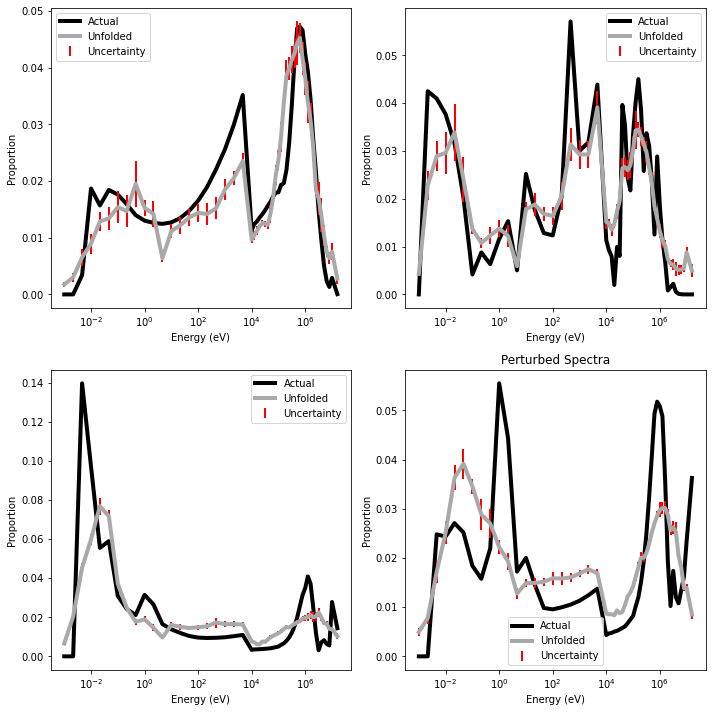

In [222]:
MODELS = models_PSA

rows = 2
cols = 2

fig, axs = plt.subplots(rows, cols, figsize=(10,10))

for x in range(rows):
    for y in range(cols):
        i = (2 * x) + y
        
        axs[x][y].plot(Ebins, ytest[i], label = "Actual", color = "black", linewidth = 4)
        
        preds = []
        
        for model in MODELS:
            preds.append(model(xtest[i:i+1])[0])
        
        meanPred = []
        stdPred = []
        for i in range(len(preds[0])):
            pred = []
            for p in preds:
                pred.append(p[i])
                
            meanPred.append(np.mean(pred))
            stdPred.append(np.std(pred))
            
        axs[x][y].errorbar(Ebins, meanPred, yerr = stdPred, color = "red", linewidth = 2, label = "Uncertainty", linestyle = '')
        axs[x][y].plot(Ebins, meanPred, color = "darkgrey", linewidth = 4, alpha = 1, label = "Unfolded")
        
        axs[x][y].set_xscale("log")
        axs[x][y].set_xlabel("Energy (eV)")
        axs[x][y].set_ylabel("Proportion")
        axs[x][y].legend()
        
plt.tight_layout()

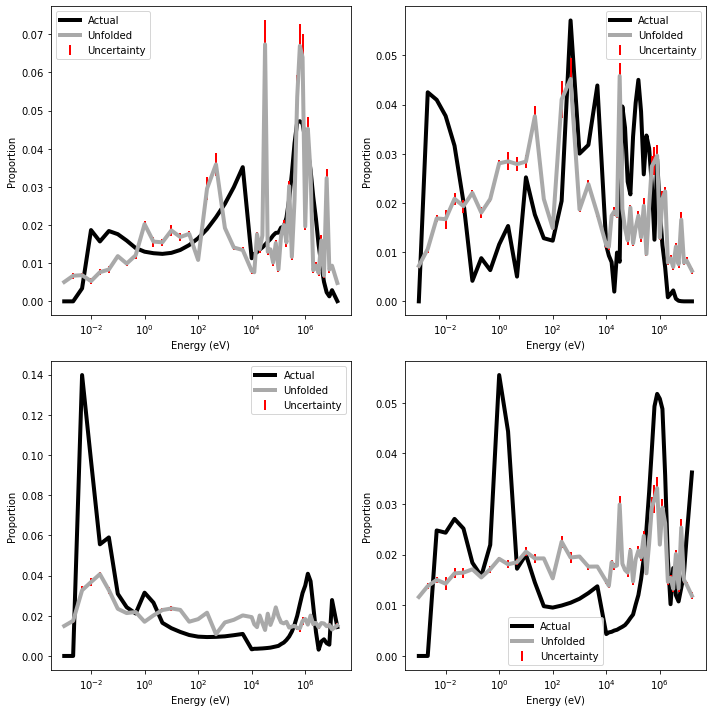

In [219]:
MODELS = models_GAN

rows = 2
cols = 2

fig, axs = plt.subplots(rows, cols, figsize=(10,10))

for x in range(rows):
    for y in range(cols):
        i = (2 * x) + y
        
        axs[x][y].plot(Ebins, ytest[i], label = "Actual", color = "black", linewidth = 4)
        
        preds = []
        
        for model in MODELS:
            preds.append(model(xtest[i:i+1])[0])
        
        meanPred = []
        stdPred = []
        for i in range(len(preds[0])):
            pred = []
            for p in preds:
                pred.append(p[i])
                
            meanPred.append(np.mean(pred))
            stdPred.append(np.std(pred))
            
        axs[x][y].errorbar(Ebins, meanPred, yerr = stdPred, color = "red", linewidth = 2, label = "Uncertainty", linestyle = '')
        axs[x][y].plot(Ebins, meanPred, color = "darkgrey", linewidth = 4, alpha = 1, label = "Unfolded")
        
        axs[x][y].set_xscale("log")
        axs[x][y].set_xlabel("Energy (eV)")
        axs[x][y].set_ylabel("Proportion")
        axs[x][y].legend()
        
plt.tight_layout()

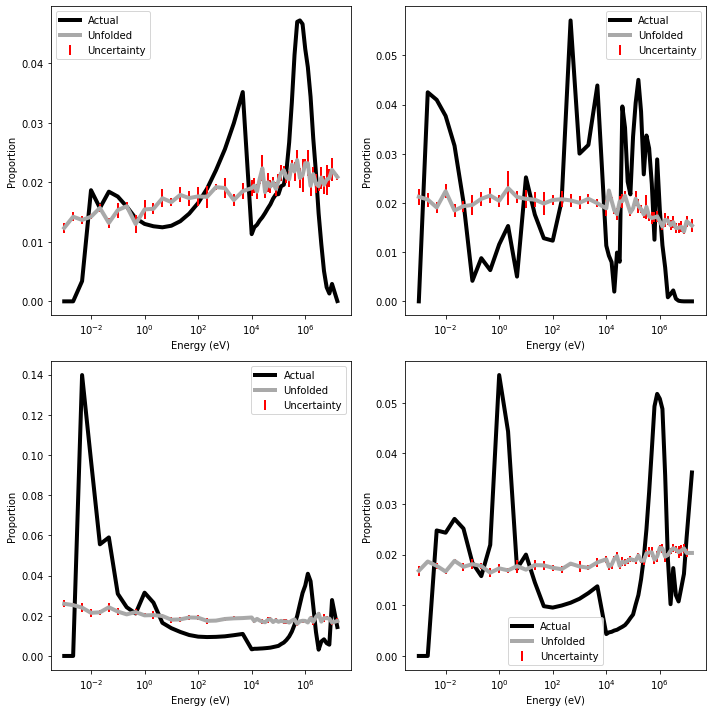

In [220]:
MODELS = models_RAND

rows = 2
cols = 2

fig, axs = plt.subplots(rows, cols, figsize=(10,10))

for x in range(rows):
    for y in range(cols):
        i = (2 * x) + y
        
        axs[x][y].plot(Ebins, ytest[i], label = "Actual", color = "black", linewidth = 4)
        
        preds = []
        
        for model in MODELS:
            preds.append(model(xtest[i:i+1])[0])
        
        meanPred = []
        stdPred = []
        for i in range(len(preds[0])):
            pred = []
            for p in preds:
                pred.append(p[i])
                
            meanPred.append(np.mean(pred))
            stdPred.append(np.std(pred))
            
        axs[x][y].errorbar(Ebins, meanPred, yerr = stdPred, color = "red", linewidth = 2, label = "Uncertainty", linestyle = '')
        axs[x][y].plot(Ebins, meanPred, color = "darkgrey", linewidth = 4, alpha = 1, label = "Unfolded")
        
        axs[x][y].set_xscale("log")
        axs[x][y].set_xlabel("Energy (eV)")
        axs[x][y].set_ylabel("Proportion")
        axs[x][y].legend()
        
plt.tight_layout()

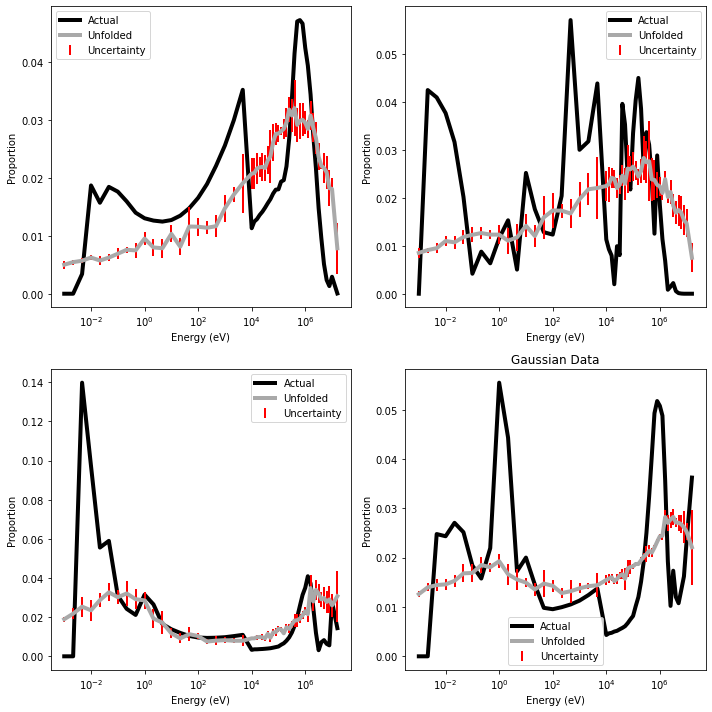

In [238]:
MODELS = models_GAUSS

rows = 2
cols = 2

fig, axs = plt.subplots(rows, cols, figsize=(10,10))

for x in range(rows):
    for y in range(cols):
        i = (2 * x) + y
        
        axs[x][y].plot(Ebins, ytest[i], label = "Actual", color = "black", linewidth = 4)
        
        preds = []
        
        for model in MODELS:
            preds.append(model(xtest[i:i+1])[0])
        
        meanPred = []
        stdPred = []
        for i in range(len(preds[0])):
            pred = []
            for p in preds:
                pred.append(p[i])
                
            meanPred.append(np.mean(pred))
            stdPred.append(np.std(pred))
            
        axs[x][y].errorbar(Ebins, meanPred, yerr = stdPred, color = "red", linewidth = 2, label = "Uncertainty", linestyle = '')
        axs[x][y].plot(Ebins, meanPred, color = "darkgrey", linewidth = 4, alpha = 1, label = "Unfolded")
        
        axs[x][y].set_xscale("log")
        axs[x][y].set_xlabel("Energy (eV)")
        axs[x][y].set_ylabel("Proportion")
        axs[x][y].legend()
        
    plt.title("Gaussian Data")
        
plt.tight_layout()